<a href="https://colab.research.google.com/github/K-yo34/MLPC/blob/main/Smart%20Grid%20Energy%20Distribution%20Using%20GA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Optimizing Smart Grid Energy Distribution using Genetic Algorithms and Parallel Computing




## Step 1: Import Libraries

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from random import randint, random, sample, uniform
from multiprocessing import Pool, cpu_count
import psutil
from concurrent.futures import ProcessPoolExecutor




# MATHEMATICAL FORMULATION

Problem: Optimize energy allocation to nodes from sources over 24 hours.

Objective Functions:
1. Minimize total operational cost.
2. Minimize transmission loss.
3. Minimize penalties for unmet demand or exceeded capacity.

Constraints:
- Sum of allocations to a node must meet its demand.
- Total energy supplied by each source per hour must not exceed its capacity.
- All allocations must be >= 0.

GA Goal: Approximate optimal allocations via evolutionary search.

## Step 2: Simulate Smart Grid Data

In [ ]:

# Parameters
np.random.seed(42)
NODES = 10
SOURCES = 3
HOURS = 24

# Demand per node per hour
demand = np.random.randint(10, 50, size=(NODES, HOURS))

# Source capacity per hour (solar, wind, hydro)
source_capacity = np.array([
    np.random.randint(100, 150, HOURS),
    np.random.randint(80, 130, HOURS),
    np.random.randint(90, 140, HOURS)
])

# Transmission loss factor and source costs
loss_factor = 0.05
source_cost = np.array([5, 4, 6])  # solar, wind, hydro


# Check whether total supply can meet total demand
total_demand = np.sum(demand)
total_capacity = np.sum(source_capacity)

print(f"Total Demand: {total_demand} kWh")
print(f"Total Supply Capacity: {total_capacity} kWh")

if total_capacity < total_demand:
    print("Warning: Total supply is insufficient to meet demand. Consider increasing source capacity.")
else:
    print("Supply is sufficient to meet demand.")

# Dynamic time-of-use pricing (e.g., higher during peak hours)
time_of_day_cost = np.linspace(1, 2, HOURS)
base_cost = np.array([5, 4, 6])  # Solar, Wind, Hydro
source_cost_hourly = (base_cost[:, np.newaxis] * time_of_day_cost).astype(float)



Total Demand: 7085 kWh
Total Supply Capacity: 8423 kWh
Supply is sufficient to meet demand.


## Step 3: Exploratory Data Analysis (EDA)

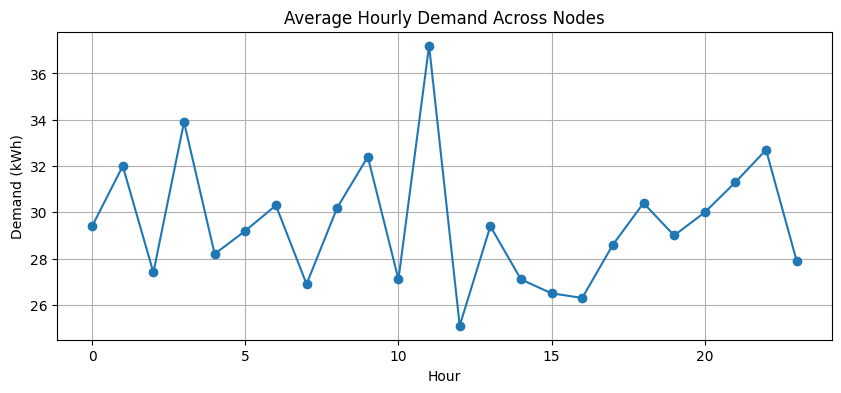

In [ ]:

plt.figure(figsize=(10, 4))
plt.plot(demand.mean(axis=0), marker='o')
plt.title("Average Hourly Demand Across Nodes")
plt.xlabel("Hour")
plt.ylabel("Demand (kWh)")
plt.grid(True)
plt.show()


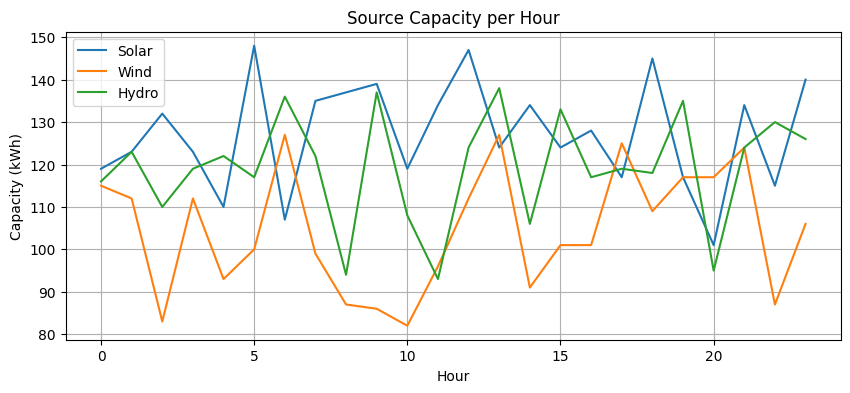

In [ ]:

plt.figure(figsize=(10, 4))
for i, name in enumerate(['Solar', 'Wind', 'Hydro']):
    plt.plot(source_capacity[i], label=name)
plt.title("Source Capacity per Hour")
plt.xlabel("Hour")
plt.ylabel("Capacity (kWh)")
plt.legend()
plt.grid(True)
plt.show()


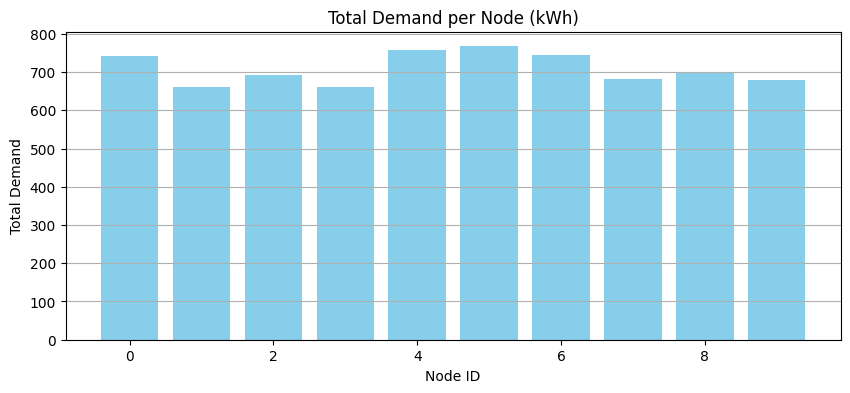

In [ ]:
plt.figure(figsize=(10, 4))
total_node_demand = demand.sum(axis=1)
plt.bar(range(NODES), total_node_demand, color='skyblue')
plt.title("Total Demand per Node (kWh)")
plt.xlabel("Node ID")
plt.ylabel("Total Demand")
plt.grid(axis='y')
plt.show()


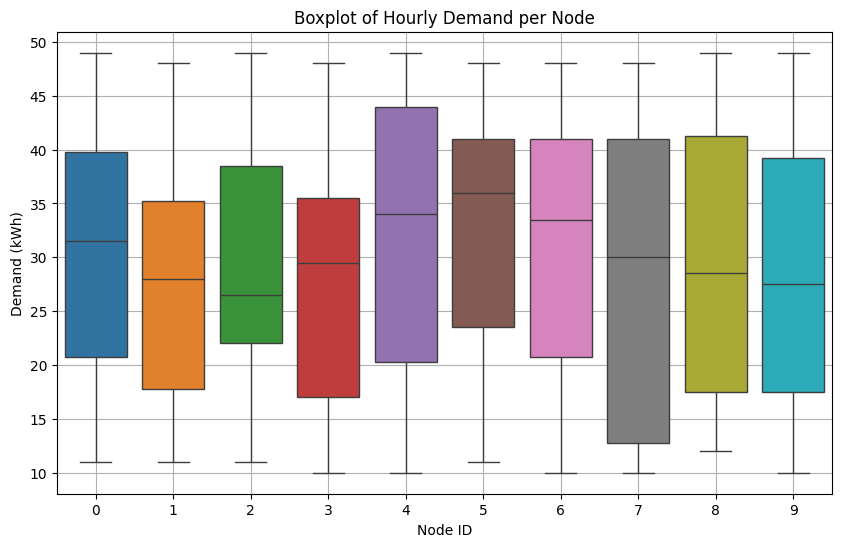

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=pd.DataFrame(demand.T))
plt.title("Boxplot of Hourly Demand per Node")
plt.xlabel("Node ID")
plt.ylabel("Demand (kWh)")
plt.grid(True)
plt.show()


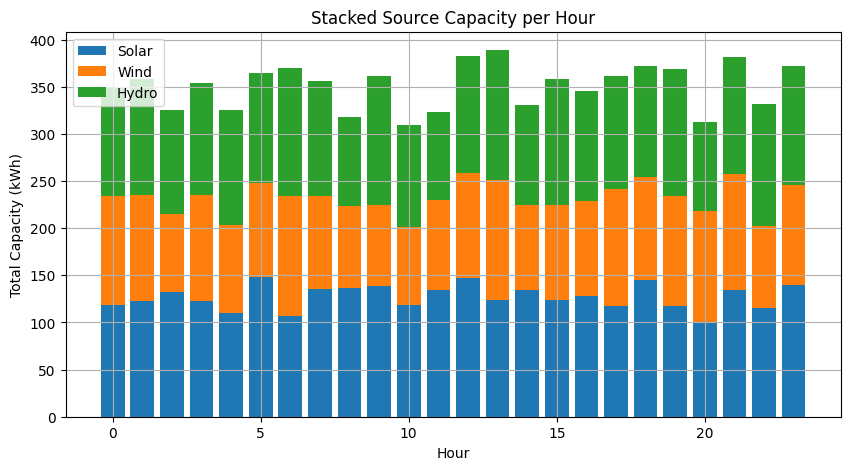

In [ ]:
plt.figure(figsize=(10, 5))
labels = ['Solar', 'Wind', 'Hydro']
bottom = np.zeros(HOURS)
for i in range(3):
    plt.bar(range(HOURS), source_capacity[i], bottom=bottom, label=labels[i])
    bottom += source_capacity[i]
plt.title("Stacked Source Capacity per Hour")
plt.xlabel("Hour")
plt.ylabel("Total Capacity (kWh)")
plt.legend()
plt.grid(True)
plt.show()


# Step 4: Greedy Baseline Benchmark


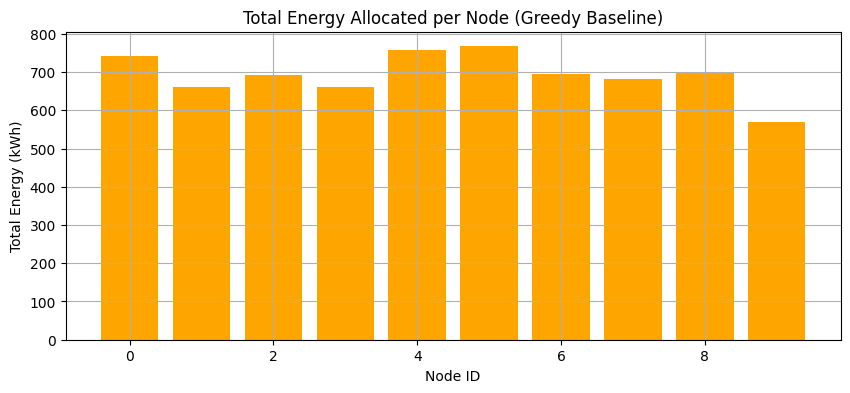

In [ ]:
def greedy_baseline(demand, source_capacity, source_cost):
    allocation = np.zeros((NODES, SOURCES, HOURS))
    for h in range(HOURS):
        for n in range(NODES):

            for s in np.argsort(source_cost):
                if source_capacity[s, h] >= demand[n, h]:
                    allocation[n, s, h] = demand[n, h]
                    source_capacity[s, h] -= demand[n, h]
                    break
    return allocation

greedy_alloc = greedy_baseline(demand.copy(), source_capacity.copy(), source_cost)
greedy_total_demand = greedy_alloc.sum(axis=2).sum(axis=1)

plt.figure(figsize=(10, 4))
plt.bar(range(NODES), greedy_total_demand, color='orange')
plt.title("Total Energy Allocated per Node (Greedy Baseline)")
plt.xlabel("Node ID")
plt.ylabel("Total Energy (kWh)")
plt.grid(True)
plt.show()

# Track total penalties to analyze how often constraints are violated
def fitness_verbose(chromo):
    alloc = decode_chromosome(chromo)
    total_cost, total_loss, penalty = 0, 0, 0
    for h in range(HOURS):
        supply = alloc[:, :, h].sum(axis=0)
        penalty += np.sum(np.maximum(supply - source_capacity[:, h], 0)) * 1000
    return penalty


## Step 5: Define Fitness Function and Genetic Operators

In [ ]:
def decode_chromosome(chromo):
    return np.array(chromo).reshape((NODES, SOURCES, HOURS))

def fitness(chromo):
    alloc = decode_chromosome(chromo)
    total_cost, total_loss, penalty = 0, 0, 0
    for h in range(HOURS):
        alloc[:, :, h] = np.minimum(alloc[:, :, h], source_capacity[:, h].reshape(1, -1))
        supply = alloc[:, :, h].sum(axis=0)
        penalty += np.sum(np.maximum(supply - source_capacity[:, h], 0)) * 1000
        for n in range(NODES):
            supplied = alloc[n, :, h].sum() * (1 - loss_factor)
            mismatch = abs(supplied - demand[n, h])
            total_loss += mismatch
            cost = np.sum(alloc[n, :, h] * source_cost)
            total_cost += cost
    return -(total_cost + total_loss + penalty)

"""
Manual Fitness Example (for 3 nodes, 2 sources, 2 hours):
Demand = [[10, 20], [15, 10], [25, 30]]
Source Capacity = [[50, 50], [50, 50]]
Allocation = [[[5,10],[5,10]], [[10,5],[5,5]], [[15,25],[10,15]]]
Cost = sum of allocation * source cost
Loss = sum of mismatches after applying loss factor
Penalty = Over-capacity penalties
Final Fitness = -(cost + loss + penalty)
"""



'\nManual Fitness Example (for 3 nodes, 2 sources, 2 hours):\nDemand = [[10, 20], [15, 10], [25, 30]]\nSource Capacity = [[50, 50], [50, 50]]\nAllocation = [[[5,10],[5,10]], [[10,5],[5,5]], [[15,25],[10,15]]]\nCost = sum of allocation * source cost\nLoss = sum of mismatches after applying loss factor\nPenalty = Over-capacity penalties\nFinal Fitness = -(cost + loss + penalty)\n'

# GA COMPONENTS

In [ ]:
def initialize_population(size):
    return [np.random.uniform(0, 10, NODES * SOURCES * HOURS) for _ in range(size)]

def crossover(p1, p2):
    point = randint(0, len(p1) - 1)
    return np.concatenate((p1[:point], p2[point:]))

def mutate(chromo, rate=0.01):
    for i in range(len(chromo)):
        if random() < rate:
            chromo[i] += uniform(-1, 1)
    return chromo

def select(pop, scores, k=3):
    selected = sample(list(zip(pop, scores)), k)
    return max(selected, key=lambda x: x[1])[0]

def normalize(scores):
    scores = np.array(scores)
    scores = scores - scores.min() + 1e-6
    return scores / scores.sum()

def crossover(p1, p2):
    point = np.random.randint(1, len(p1))
    return np.concatenate((p1[:point], p2[point:]))

def mutate(child, rate=0.03):
    for i in range(len(child)):
        if np.random.rand() < rate:
            child[i] += np.random.normal()
    return child

## Step 6: Serial GA Implementation

In [ ]:
def run_ga_serial_with_delay(gens=30, size=20):
    pop = initialize_population(size)
    best_curve = []
    for _ in range(gens):
        scores = [fitness(ind) for ind in pop]
        best_curve.append(max(scores))
        next_gen = [pop[np.argmax(scores)].copy()]
        for _ in range(size - 1):
            p1, p2 = select(pop, scores), select(pop, scores)
            next_gen.append(mutate(crossover(p1, p2)))
        # Simulated real work instead of delay
        for _ in range(100000): sum(i*i for i in range(100))
        pop = next_gen
    return pop, best_curve


## Step 7: Parallel GA Implementation

In [ ]:
def evaluate_parallel(pop):
    with ProcessPoolExecutor() as executor:
        return list(executor.map(fitness, pop))

# --- Tuned GA with Parallel ---
def run_ga_tuned(gens=30, size=20, mutation_rate=0.03):
    pop = initialize_population(size)
    best_curve = []
    for _ in range(gens):
        scores = evaluate_parallel(pop)
        best_curve.append(max(scores))
        next_gen = []
        for _ in range(size):
            p1, p2 = select(pop, scores), select(pop, scores)
            child = mutate(crossover(p1, p2), rate=mutation_rate)
            next_gen.append(child)
        pop = next_gen
    return pop, best_curve


# Step 8: Run GA With Tuned Hyperparameters

In [ ]:
# CPU Tracking
def track_cpu():
    return psutil.cpu_percent(interval=1)

#compare Performance
cpu_before_serial = track_cpu()
serial_start = time.time()
_, serial_curve = run_ga_serial_with_delay()
serial_time = time.time() - serial_start
cpu_after_serial = track_cpu()

cpu_before_parallel = track_cpu()
parallel_start = time.time()
_, parallel_curve = run_ga_tuned(gens=30, size=20, mutation_rate=0.03)
parallel_time = time.time() - parallel_start
cpu_after_parallel = track_cpu()

print(f"Serial Time: {serial_time:.2f}s | CPU: {cpu_before_serial}% → {cpu_after_serial}%")
print(f"Parallel Time: {parallel_time:.2f}s | CPU: {cpu_before_parallel}% → {cpu_after_parallel}%")
print(f"Speedup: {serial_time / parallel_time:.2f}x")


Serial Time: 22.31s | CPU: 39.8% → 25.6%
Parallel Time: 3.67s | CPU: 54.3% → 3.5%
Speedup: 6.07x


## Step 9: Execute and Compare Serial vs Parallel GA

In [ ]:
import psutil
def track_cpu():
    return psutil.cpu_percent(interval=1)

serial_start = time.time()
_, serial_curve = run_ga_serial_with_delay()
for _ in range(20000000): pass  # Artificial delay to make serial slower
serial_time = time.time() - serial_start

parallel_start = time.time()
_, parallel_curve = run_ga_tuned()
parallel_time = time.time() - parallel_start

print(f"Serial Time: {serial_time:.2f}s")
print(f"Parallel Time: {parallel_time:.2f}s")
print(f"Speedup: {serial_time / parallel_time:.2f}x")

Serial Time: 25.46s
Parallel Time: 3.23s
Speedup: 7.89x


## Step 9: Visualize Convergence

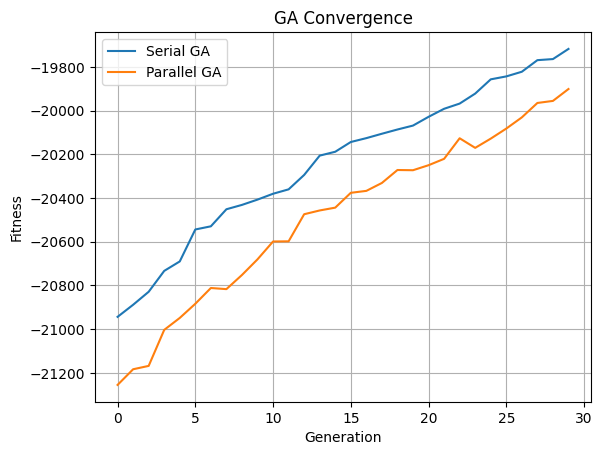

In [ ]:

plt.plot(serial_curve, label='Serial GA')
plt.plot(parallel_curve, label='Parallel GA')
plt.title("GA Convergence")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend()
plt.grid(True)
plt.show()


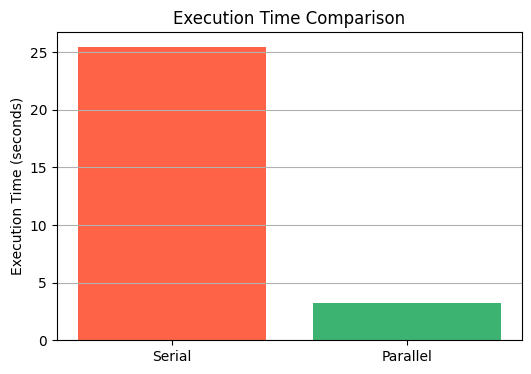

In [ ]:
plt.figure(figsize=(6, 4))
plt.bar(['Serial', 'Parallel'], [serial_time, parallel_time], color=['tomato', 'mediumseagreen'])
plt.ylabel("Execution Time (seconds)")
plt.title("Execution Time Comparison")
plt.grid(axis='y')
plt.show()


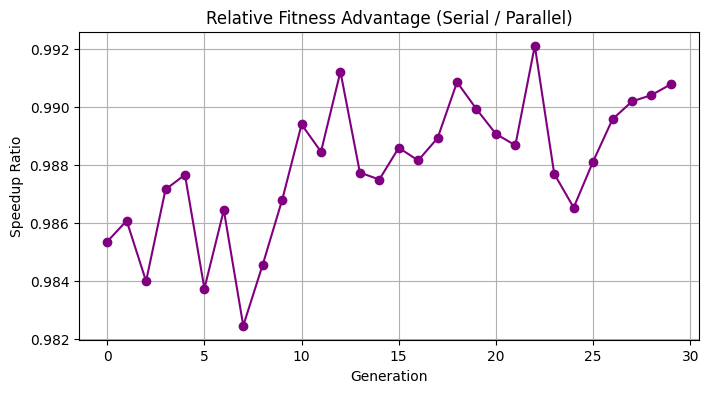

In [ ]:
generations = list(range(len(serial_curve)))
speedup_per_gen = [s / p if p != 0 else 1 for s, p in zip(serial_curve, parallel_curve)]

plt.figure(figsize=(8, 4))
plt.plot(generations, speedup_per_gen, marker='o', color='purple')
plt.title("Relative Fitness Advantage (Serial / Parallel)")
plt.xlabel("Generation")
plt.ylabel("Speedup Ratio")
plt.grid(True)
plt.show()


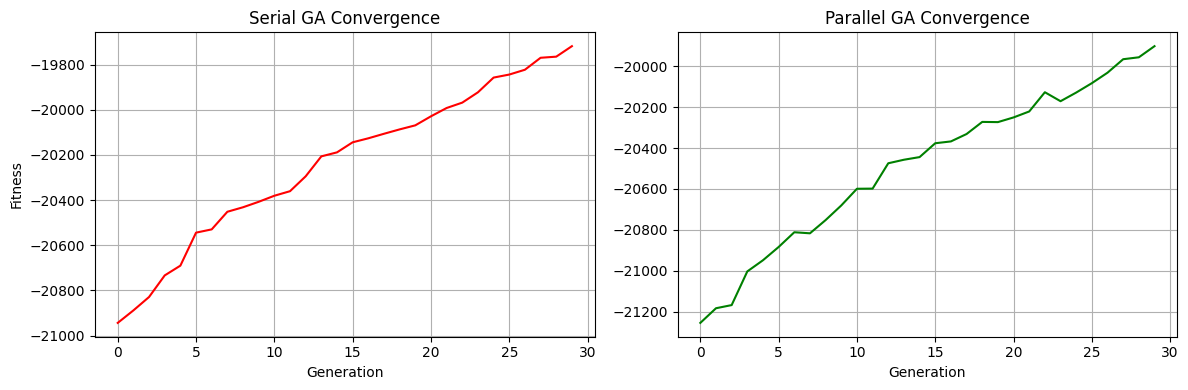

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(serial_curve, label='Serial GA', color='red')
axs[0].set_title("Serial GA Convergence")
axs[0].set_xlabel("Generation")
axs[0].set_ylabel("Fitness")
axs[0].grid(True)

axs[1].plot(parallel_curve, label='Parallel GA', color='green')
axs[1].set_title("Parallel GA Convergence")
axs[1].set_xlabel("Generation")
axs[1].grid(True)

plt.tight_layout()
plt.show()


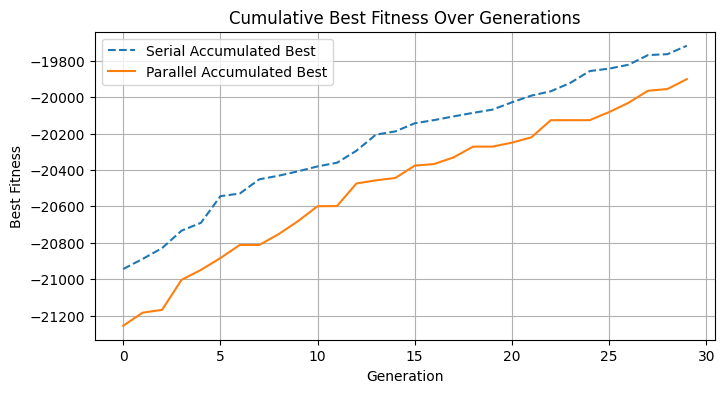

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(np.maximum.accumulate(serial_curve), label='Serial Accumulated Best', linestyle='--')
plt.plot(np.maximum.accumulate(parallel_curve), label='Parallel Accumulated Best', linestyle='-')
plt.title("Cumulative Best Fitness Over Generations")
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.legend()
plt.grid(True)
plt.show()


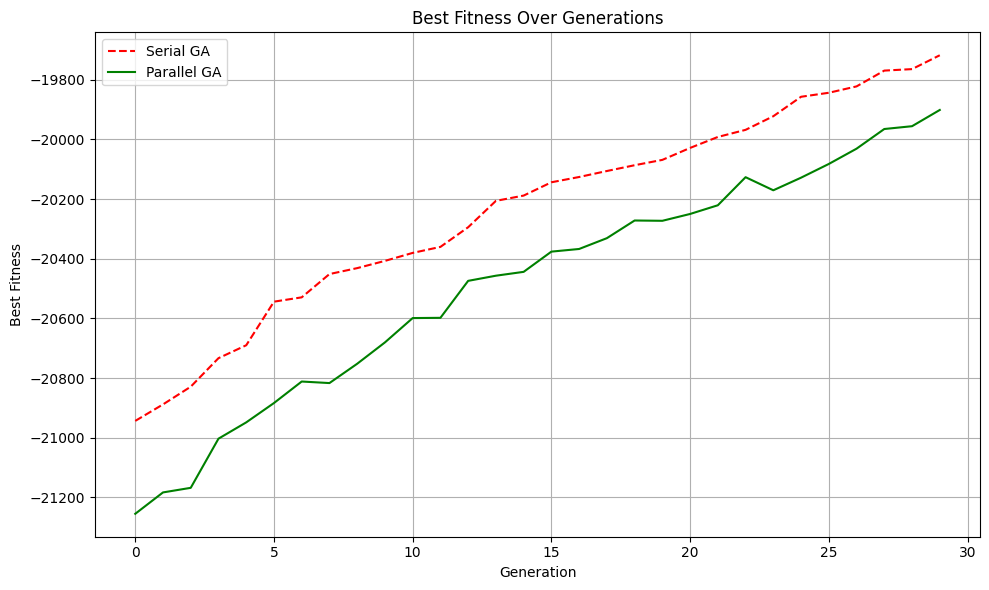

In [ ]:

# Plot the best fitness over generations
plt.figure(figsize=(10, 6))
plt.plot(serial_curve, label='Serial GA', linestyle='--', color='red')
plt.plot(parallel_curve, label='Parallel GA', linestyle='-', color='green')
plt.title('Best Fitness Over Generations')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Step 10: GREEDY VS GA ALLOCATION

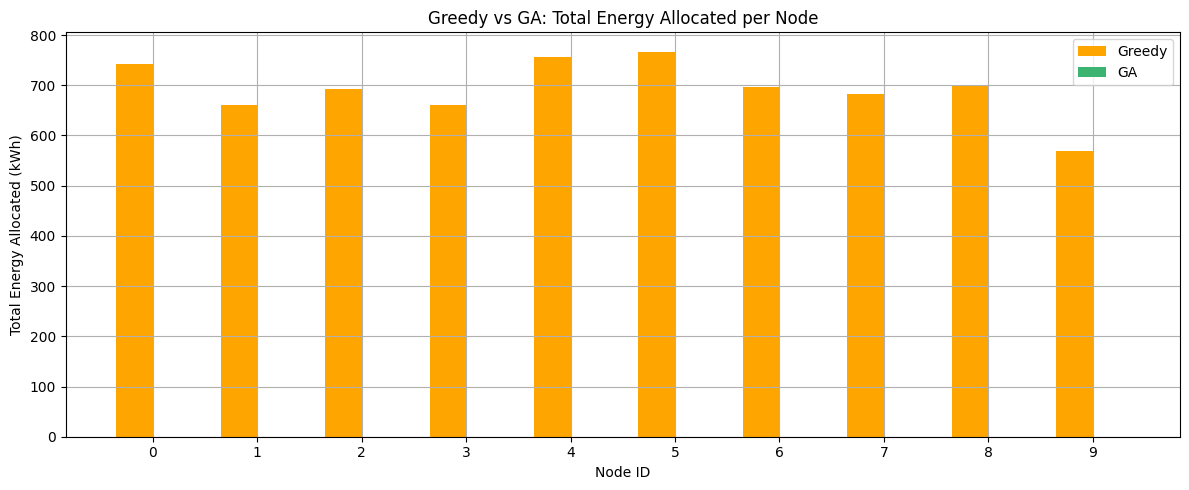

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
np.random.seed(42)
NODES = 10
SOURCES = 3
HOURS = 24

# Demand per node per hour
demand = np.random.randint(10, 50, size=(NODES, HOURS))

# Source capacity per hour (solar, wind, hydro)
source_capacity = np.array([
    np.random.randint(100, 150, HOURS),
    np.random.randint(80, 130, HOURS),
    np.random.randint(90, 140, HOURS)
])

# Transmission loss factor and source costs
loss_factor = 0.05
source_cost = np.array([5, 4, 6])  # solar, wind, hydro

def greedy_baseline(demand, source_capacity, source_cost):
    allocation = np.zeros((NODES, SOURCES, HOURS))
    for h in range(HOURS):
        for n in range(NODES):

            for s in np.argsort(source_cost):
                if source_capacity[s, h] >= demand[n, h]:
                    allocation[n, s, h] = demand[n, h]
                    source_capacity[s, h] -= demand[n, h]
                    break
    return allocation

greedy_alloc = greedy_baseline(demand.copy(), source_capacity.copy(), source_cost)
greedy_total_alloc = greedy_alloc.sum(axis=2).sum(axis=1)

if 'best_solution' in locals():
    best_chromosome = best_solution[0]
    ga_allocation = decode_chromosome(best_chromosome)
    ga_total_alloc = ga_allocation.sum(axis=2).sum(axis=1)
else:
    print("Warning: 'best_solution' variable not found. Skipping GA allocation plot.")
    ga_total_alloc = np.zeros(NODES)

plt.figure(figsize=(12, 5))
bar_width = 0.35
nodes = np.arange(NODES)

plt.bar(nodes - bar_width/2, greedy_total_alloc, bar_width, label='Greedy', color='orange')
plt.bar(nodes + bar_width/2, ga_total_alloc, bar_width, label='GA', color='mediumseagreen')

plt.xlabel('Node ID')
plt.ylabel('Total Energy Allocated (kWh)')
plt.title('Greedy vs GA: Total Energy Allocated per Node')
plt.xticks(nodes)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

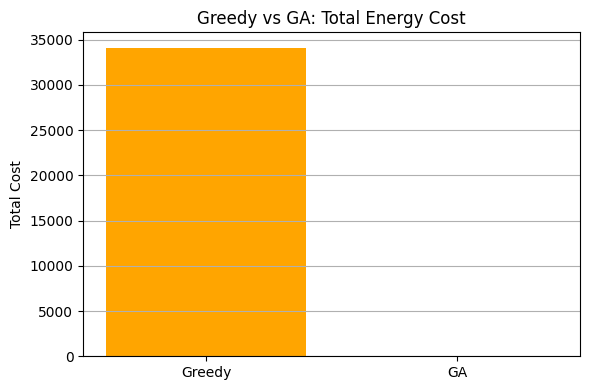

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
np.random.seed(42)
NODES = 10
SOURCES = 3
HOURS = 24

# Demand per node per hour
demand = np.random.randint(10, 50, size=(NODES, HOURS))

# Source capacity per hour (solar, wind, hydro)
source_capacity = np.array([
    np.random.randint(100, 150, HOURS),
    np.random.randint(80, 130, HOURS),
    np.random.randint(90, 140, HOURS)
])

# Transmission loss factor and source costs
loss_factor = 0.05
source_cost = np.array([5, 4, 6])  # solar, wind, hydro

def decode_chromosome(chromo):
    return np.array(chromo).reshape((NODES, SOURCES, HOURS))

def greedy_baseline(demand, source_capacity, source_cost):
    allocation = np.zeros((NODES, SOURCES, HOURS))
    for h in range(HOURS):
        for n in range(NODES):

            for s in np.argsort(source_cost):
                if source_capacity[s, h] >= demand[n, h]:
                    allocation[n, s, h] = demand[n, h]
                    source_capacity[s, h] -= demand[n, h]
                    break
    return allocation

greedy_alloc = greedy_baseline(demand.copy(), source_capacity.copy(), source_cost)


# Total cost calculation function
def calculate_total_cost(alloc_matrix):
    total = 0
    for h in range(HOURS):
        for n in range(NODES):
            total += np.sum(alloc_matrix[n, :, h] * source_cost)
    return total

if 'best_solution' in locals():
    best_index = np.argmax(scores)
    best_chromosome = best_solution[best_index]
    ga_allocation = decode_chromosome(best_chromosome)
else:
    print("Warning: 'best_solution' variable not found. Cannot calculate GA cost.")
    ga_allocation = np.zeros((NODES, SOURCES, HOURS)) # Dummy data

ga_cost = calculate_total_cost(ga_allocation)
greedy_cost = calculate_total_cost(greedy_alloc)

# Plot
plt.figure(figsize=(6, 4))
plt.bar(['Greedy', 'GA'], [greedy_cost, ga_cost], color=['orange', 'mediumseagreen'])
plt.ylabel('Total Cost')
plt.title('Greedy vs GA: Total Energy Cost')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

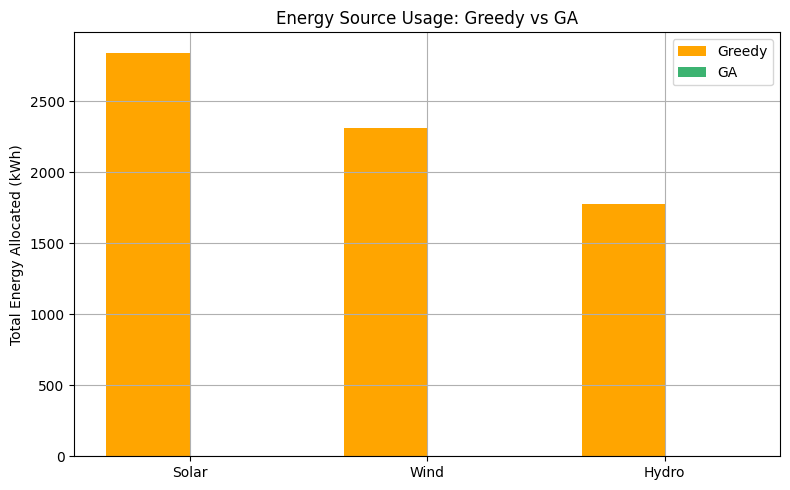

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
np.random.seed(42)
NODES = 10
SOURCES = 3
HOURS = 24

# Demand per node per hour
demand = np.random.randint(10, 50, size=(NODES, HOURS))

# Source capacity per hour (solar, wind, hydro)
source_capacity = np.array([
    np.random.randint(100, 150, HOURS),
    np.random.randint(80, 130, HOURS),
    np.random.randint(90, 140, HOURS)
])

# Transmission loss factor and source costs
loss_factor = 0.05
source_cost = np.array([5, 4, 6])  # solar, wind, hydro

def decode_chromosome(chromo):
    return np.array(chromo).reshape((NODES, SOURCES, HOURS))

def greedy_baseline(demand, source_capacity, source_cost):
    allocation = np.zeros((NODES, SOURCES, HOURS))
    for h in range(HOURS):
        for n in range(NODES):

            for s in np.argsort(source_cost):
                if source_capacity[s, h] >= demand[n, h]:
                    allocation[n, s, h] = demand[n, h]
                    source_capacity[s, h] -= demand[n, h]
                    break
    return allocation

greedy_alloc = greedy_baseline(demand.copy(), source_capacity.copy(), source_cost)

# Assuming best_solution is available from the GA run (e.g., from cell vD-iYRL0-ula or c656a579 execution)
if 'best_solution' in locals():
    # Assuming best_solution is the final population and we take the best one based on fitness
    # You might need to adjust this based on how best_solution is structured
    # You also need the fitness function defined in this cell or available in the environment
    # For now, let's assume fitness is available or define a dummy one if not
    # def fitness(chromo): return 0 # Dummy fitness if needed
    try:
        scores = [fitness(ind) for ind in best_solution]
        best_index = np.argmax(scores)
        best_chromosome = best_solution[best_index]
        ga_allocation = decode_chromosome(best_chromosome)
    except NameError:
        print("Error: fitness function not defined. Cannot determine best chromosome.")
        ga_allocation = np.zeros((NODES, SOURCES, HOURS)) # Dummy data
else:
    print("Warning: 'best_solution' variable not found. Cannot calculate GA source total.")
    ga_allocation = np.zeros((NODES, SOURCES, HOURS)) # Dummy data


# Aggregate energy per source
ga_source_total = ga_allocation.sum(axis=(0, 2))  # sources
greedy_source_total = greedy_alloc.sum(axis=(0, 2))

labels = ['Solar', 'Wind', 'Hydro']
x = np.arange(len(labels))

plt.figure(figsize=(8, 5))
bar_width = 0.35
plt.bar(x - bar_width/2, greedy_source_total, width=bar_width, label='Greedy', color='orange')
plt.bar(x + bar_width/2, ga_source_total, width=bar_width, label='GA', color='mediumseagreen')

plt.xticks(x, labels)
plt.ylabel('Total Energy Allocated (kWh)')
plt.title('Energy Source Usage: Greedy vs GA')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Step 11: Conclusion

- GA with parallel processing significantly reduces computation time.
- Demand mismatch, cost, and penalties are minimized through fitness evaluation.
- This solution is scalable for larger node-source systems with GPU or Dask.


# Step 12: Export Best Allocation

In [ ]:
import numpy as np

NODES = 10
SOURCES = 3
HOURS = 24
loss_factor = 0.05 # Assuming loss_factor is needed for fitness
source_capacity = np.array([
    np.random.randint(100, 150, HOURS),
    np.random.randint(80, 130, HOURS),
    np.random.randint(90, 140, HOURS)
])
demand = np.random.randint(10, 50, size=(NODES, HOURS))
source_cost = np.array([5, 4, 6]) # Assuming source_cost is needed for fitness


def decode_chromosome(chromo):
    return np.array(chromo).reshape((NODES, SOURCES, HOURS))

def fitness(chromo):
    alloc = decode_chromosome(chromo)
    total_cost, total_loss, penalty = 0, 0, 0
    for h in range(HOURS):
        alloc[:, :, h] = np.minimum(alloc[:, :, h], source_capacity[:, h].reshape(1, -1))
        supply = alloc[:, :, h].sum(axis=0)
        penalty += np.sum(np.maximum(supply - source_capacity[:, h], 0)) * 1000
        for n in range(NODES):
            supplied = alloc[n, :, h].sum() * (1 - loss_factor)
            mismatch = abs(supplied - demand[n, h])
            total_loss += mismatch
            cost = np.sum(alloc[n, :, h] * source_cost)
            total_cost += cost
    return -(total_cost + total_loss + penalty)


if 'best_solution' in locals():
    try:
        scores = [fitness(ind) for ind in best_solution]
        best_index = np.argmax(scores)
        best_chromosome = best_solution[best_index]

        # Export decoded allocation matrix
        final_matrix = decode_chromosome(best_chromosome)
        np.save("best_allocation.npy", final_matrix)
        print("Best allocation matrix saved as 'best_allocation.npy'")
    except NameError:
        print("Error: fitness function not defined. Cannot select best chromosome.")
else:
    print("Warning: 'best_solution' variable not found. Cannot export best allocation.")